### Jupyter Notebook Description

#### Overview
This Jupyter Notebook addresses a predictive modeling competition involving crime data from San Francisco spanning nearly 12 years. The dataset encompasses various neighborhoods, and the goal is to predict the category of crimes based on time and location information.

#### Context
From 1934 to 1963, San Francisco was notorious for housing some of the world's most infamous criminals on Alcatraz Island. Today, the city is recognized more for its technology industry than its historical criminal associations. However, despite its modern identity, issues such as wealth inequality, housing shortages, and a notable crime rate persist, making this predictive modeling challenge relevant and significant.

#### Dataset
The dataset used in this competition comprises comprehensive crime reports spanning different neighborhoods of San Francisco. It covers a wide range of crime categories and includes temporal and spatial attributes crucial for predictive analysis.

#### Objective
The primary objective of this notebook is to develop machine learning models that accurately predict the category of crimes based on the provided dataset. Evaluation of model performance is based on the multi-class logarithmic loss metric, emphasizing the importance of both precision and reliability in predictions.

#### Methodology
1. **Data Exploration**: 
   - Exploring the structure and attributes of the dataset.
   - Analyzing trends and patterns in crime occurrences across different neighborhoods and time periods.

2. **Feature Engineering**:
   - Preparing the data for modeling by selecting relevant features.
   - Encoding categorical variables and handling missing data if necessary.

3. **Model Development**:
   - Implementing various machine learning algorithms suitable for multi-class classification tasks.
   - Fine-tuning models and optimizing hyperparameters to enhance predictive accuracy.

4. **Evaluation**:
   - Assessing model performance using cross-validation techniques.
   - Optimizing models based on the multi-class logarithmic loss metric to ensure robustness and reliability.

#### Conclusion
By leveraging machine learning techniques on the San Francisco crime dataset, this notebook aims to contribute insights into crime patterns and improve predictive capabilities. The ultimate goal is to develop models that can assist in allocating resources effectively and enhancing public safety measures across the city's diverse neighborhoods.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
df = pd.read_csv("../data/San Francisco Crime Classification/train.csv", parse_dates=["Dates"])
df_test = pd.read_csv("../data/San Francisco Crime Classification/test.csv", parse_dates=["Dates"])

In [4]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
def add_dates(df):
    df["Day"] = df["Dates"].dt.day
    df["Month"] = df["Dates"].dt.month    
    df["Year"] = df["Dates"].dt.year
    
    df.drop("Dates", axis=1, inplace=True)
    return df

In [6]:
df = add_dates(df)
df_test = add_dates(df_test)

In [7]:
df.head()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Day,Month,Year
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,2015
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,13,5,2015
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,13,5,2015
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,13,5,2015
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,13,5,2015


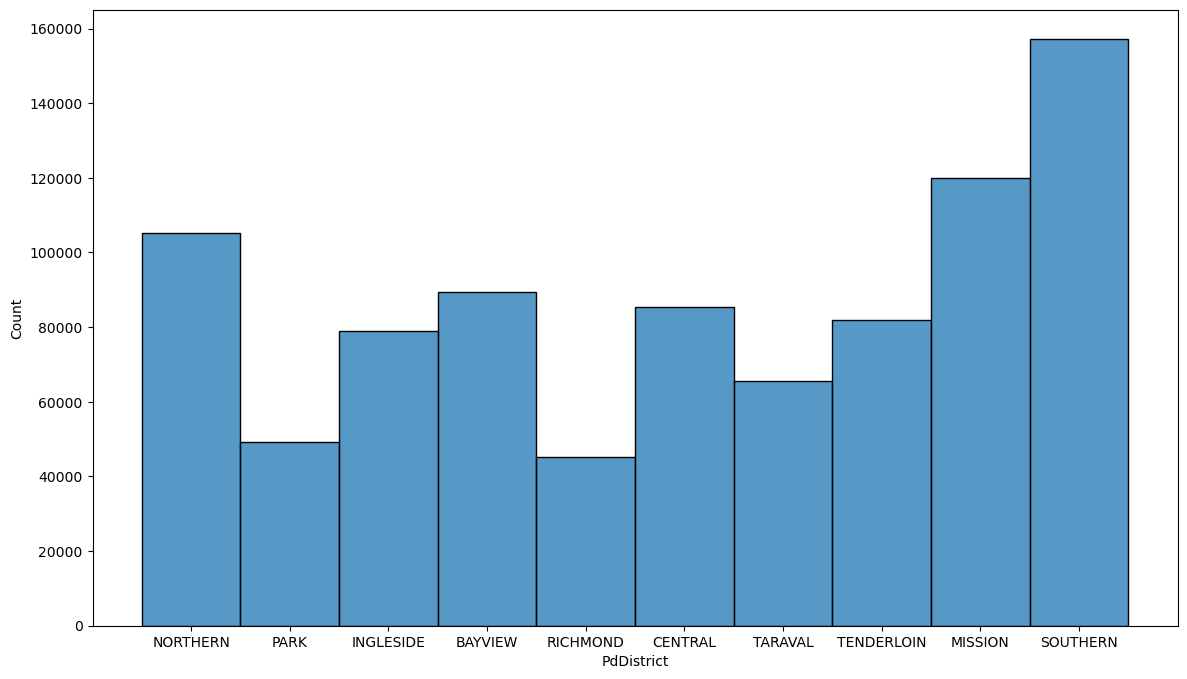

In [8]:
sns.histplot(x=df["PdDistrict"]);

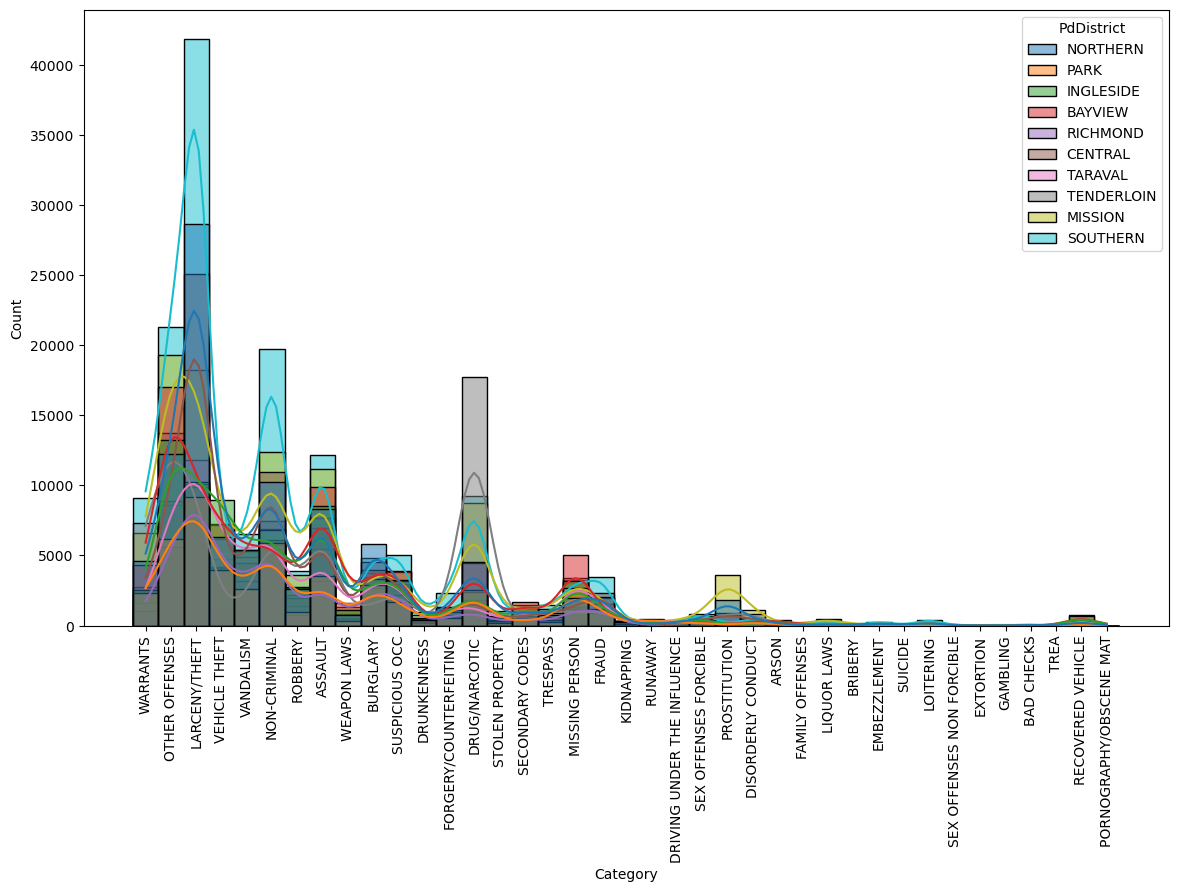

In [9]:
sns.histplot(data=df, x="Category", hue="PdDistrict", kde=True)
plt.xticks(rotation=90);

Let's remove the entries where the Resolution outcome was NONE.

In [10]:
outcome_none = df[df["Resolution"] != "NONE"]

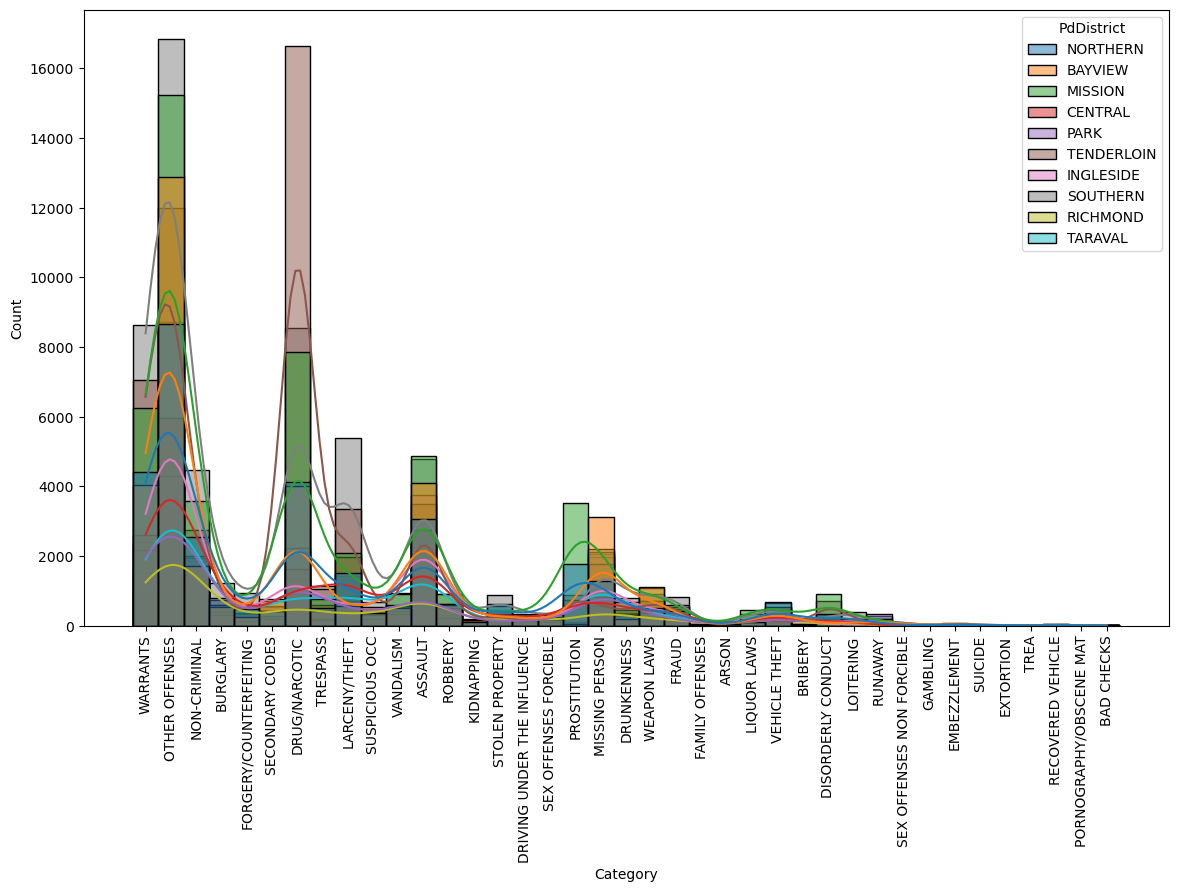

In [11]:
sns.histplot(data=outcome_none, x="Category", hue="PdDistrict", kde=True)
plt.xticks(rotation=90);

In [12]:
southern_district = df[df["PdDistrict"] == "SOUTHERN"]

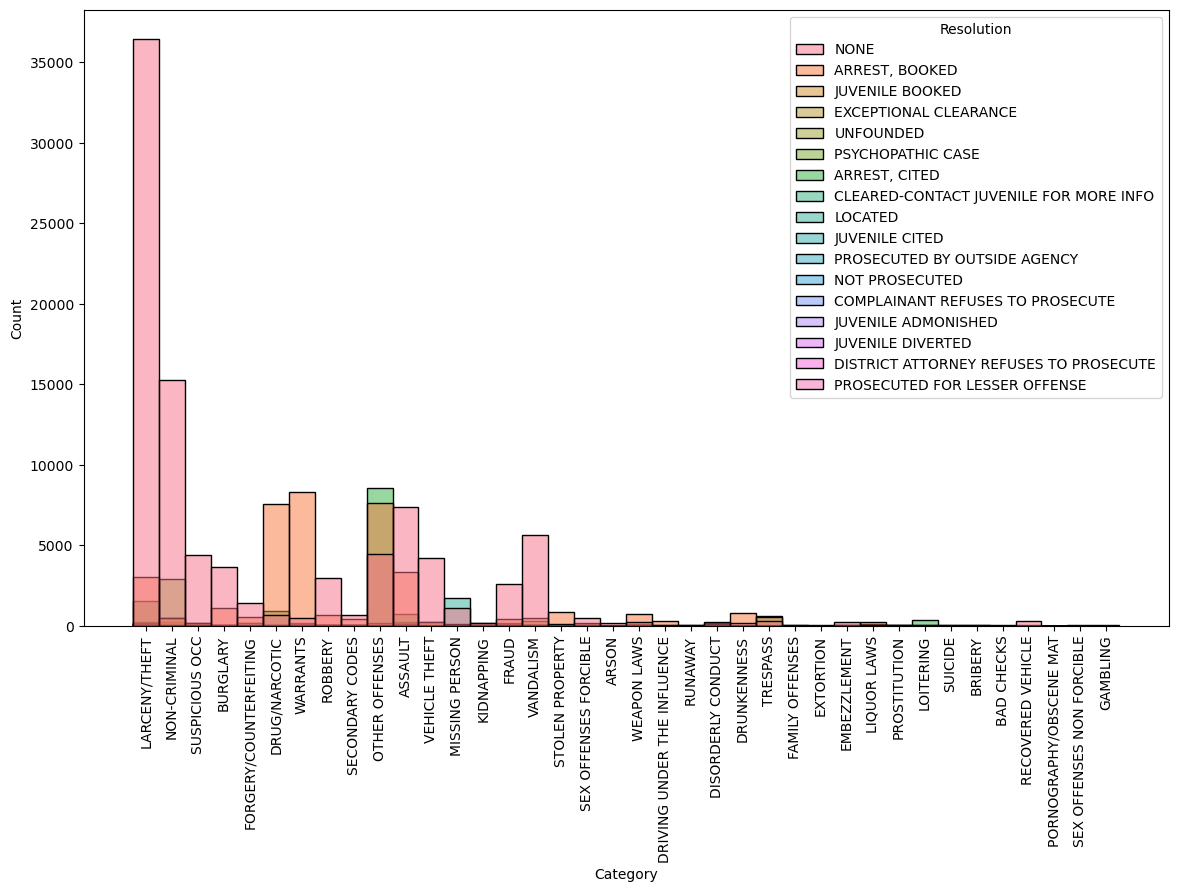

In [13]:
sns.histplot(data=southern_district, x="Category", hue="Resolution")
plt.xticks(rotation=90);

A lot of NONES in there

In [14]:
len(df["Address"].unique())

23228

In [15]:
df.isna().sum()

Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Day           0
Month         0
Year          0
dtype: int64

In [16]:
df.dtypes

Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Day             int32
Month           int32
Year            int32
dtype: object

In [17]:
set(df) - set(df_test)

{'Category', 'Descript', 'Resolution'}

We're trying to predict "Category". Let's see how our score will perform with cutting out "Descript" and "Resolution".

Otherwise, we have to predict "Descript" and "Resolution".

In [18]:
cat_labels = [c for c in df if not pd.api.types.is_numeric_dtype(df[c]) and c != "Category"]

In [19]:
cat_labels

['Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address']

In [20]:
cat_encoder = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

In [21]:
preprocessor = ColumnTransformer([
    ("cat_encoder", cat_encoder, cat_labels)
], remainder="passthrough")

In [22]:
X = df.drop("Category", axis=1)
y = df["Category"]

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [24]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_valid_encoded = preprocessor.transform(X_valid)

In [25]:
enc = LabelEncoder()

In [26]:
y_train_encoded = enc.fit_transform(y_train)
y_valid_encoded = enc.transform(y_valid)

In [27]:
model = CatBoostClassifier(task_type="GPU", devices="0")

In [28]:
model.fit(X_train_encoded, y_train_encoded, verbose=False, plot=True, eval_set=(X_valid_encoded, y_valid_encoded), 
          early_stopping_rounds=10);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
model.score(X_valid_encoded, y_valid_encoded)

0.9991040753184139

In [30]:
y_preds_proba = model.predict_proba(X_valid_encoded)

In [31]:
log_loss(y_valid_encoded, y_preds_proba)

0.030962182023305838

In [32]:
df_test.drop("Id", axis=1, inplace=True)

In [33]:
df_test.head()

,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year
0,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,10,5,2015
1,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,10,5,2015
2,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,10,5,2015
3,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,10,5,2015
4,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,10,5,2015
